In [34]:
import pandas as pd
from CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')
import numpy as np

def check_anomaly(df,metric, a1=3,a2=3, n=5, thereshold = 0.1):
    mapping = {True:1, False:0}
    # день назад и неделю назад
    df['day_ago'] = df['FifteenMinutes'] - pd.DateOffset(days=1)
    df['week_ago'] = df['FifteenMinutes'] - pd.DateOffset(days=6)
    day_ago = df[['FifteenMinutes',metric]].rename(columns={'FifteenMinutes':'day_ago',metric:metric+'_day_ago'})
    week_ago= df[['FifteenMinutes',metric]].rename(columns={'FifteenMinutes':'week_ago',metric:metric+'_week_ago'})
    df = df.merge(day_ago,how='left', sort=False).merge(week_ago,how='left', sort=False)
    
    df['diff_d'] = round((df[metric+'_day_ago'] / df[metric]) - 1,2)
    df['diff_w'] = round((df[metric+'_week_ago'] / df[metric]) - 1,2)
    df['is_alert_d'] = (abs(df['diff_d']) > thereshold).map(mapping)
    df['is_alert_w'] = (abs(df['diff_w']) > thereshold).map(mapping)     
    
    # межквартильный размах
    df['25q'] =df[metric].shift(1).rolling(n).quantile(0.25)
    df['75q'] =df[metric].shift(1).rolling(n).quantile(0.75)
    df['IQR'] =df['75q'] - df['25q']
    df['minq'] = df['25q'] -  a1  * df['IQR']
    df['maxq'] = df['75q'] +  a1 * df['IQR']
    df['minq'] = df['minq'].rolling(n,center =True, min_periods =1).mean()
    df['maxq'] = df['maxq'].rolling(n,center =True, min_periods =1).mean()
   
    df['is_alert_q'] = ((df[metric] < df['minq']) | (df[metric] > df['maxq'])).map(mapping) 
    
    #сигмы
    df['std'] = df[metric].shift(1).rolling(n).std()
    df['mean'] = df[metric].shift(1).rolling(n).mean()
    
    df['mins'] = df['mean'] - a2 * df['std']
    df['maxs'] = df['mean'] + a2 * df['std']
    
    df['mins'] = df['mins'].rolling(n,center =True, min_periods =1).mean()
    df['maxs'] = df['maxs'].rolling(n,center =True, min_periods =1).mean() 
    
    df['is_alert_s'] = ((df[metric] < df['mins']) | (df[metric] > df['maxs'])).map(mapping) 
    
    df['is_alert_sum'] = df['is_alert_s']+df['is_alert_d']+df['is_alert_w']+df['is_alert_q']
    
    if (df['is_alert_sum'].iloc[-1] >=3):          #df[metric].iloc[-1] < df['minq'].iloc[-1]  or df[metric].iloc[-1] > df['maxq'].iloc[-1]:
        is_alert = 1
    else:
        is_alert = 0
    return is_alert, df


def run_alerts(chat=None):
    #подключаемся к телеге
    chat_id = chat or 400853280
    token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
    bot = telegram.Bot(token = token)
    #выгружаем данные из базы
    data_from_base = Getch(
            '''
            with f as (
                    select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,toDate(FifteenMinutes) as date
                        ,formatDateTime(FifteenMinutes, '%R') as hm
                        ,count(distinct user_id) as dau_news
                        ,countIf(post_id, action = 'view') as view
                        ,countIf(post_id, action = 'like') as like
                        ,countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR
                    from simulator_20220520.feed_actions
                    where time < toStartOfFifteenMinutes(now())
                    group by FifteenMinutes,date,hm
            ),
            m as (select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,count(distinct user_id) as dau_message
                        ,count(user_id) as count_message 
                    from simulator_20220520.message_actions
                    where time < toStartOfFifteenMinutes(now())
                    group by FifteenMinutes
            )

            select f.FifteenMinutes as FifteenMinutes
                ,f.date as date
                ,f.hm as hm
                ,f.dau_news as dau_news
                ,f.view as view
                ,f.like as like
                ,f.CTR as CTR
                ,m.dau_message as dau_message
                ,m.count_message as count_message
                ,now() as now
            from f
            --where time < toStartOfFifteenMinutes(now())
            --toDate(time) = today() or toDate(time) = today()-1 or toDate(time) = today() -7
            full join m 
            using FifteenMinutes
            where FifteenMinutes > today() -1 --and FifteenMinutes <= '2022-06-07 11:15:00'
            order by FifteenMinutes
            '''
            ).df    
#маркеры времени для проверки
    voc = pd.DataFrame(
       [['dau_news','http://superset.lab.karpov.courses/r/1241', 'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['view','http://superset.lab.karpov.courses/r/1243',  'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['like','http://superset.lab.karpov.courses/r/1242',  'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['CTR','http://superset.lab.karpov.courses/r/1244',  'https://superset.lab.karpov.courses/superset/dashboard/988/',4,3,5,0.1], 
       ['dau_message','http://superset.lab.karpov.courses/r/1245',  'https://superset.lab.karpov.courses/superset/dashboard/988/',1.5,3,5,0.1], 
       ['count_message','http://superset.lab.karpov.courses/r/1246',  'https://superset.lab.karpov.courses/superset/dashboard/988/',2,3,7,0.1]]\
        , columns=['index','Chart_url','Dash_url','a1','a2','n','thereshold'])

    metrics_list =['dau_news','view','like','CTR','dau_message','count_message']
    for metric in metrics_list:
        df = data_from_base[['FifteenMinutes','date','hm','now',metric]].copy()
        voc_new = voc[voc['index'] == metric]
        chart = voc_new['Chart_url'].iloc[-1]
        dash = voc_new['Dash_url'].iloc[-1]
        a1 = voc_new['a1'].iloc[-1]
        a2 = voc_new['a2'].iloc[-1]        
        n = voc_new['n'].iloc[-1]
        thereshold = voc_new['thereshold'].iloc[-1]
        now = data_from_base['FifteenMinutes'].max()
        #df =  df[df.date == today]
        is_alert, df = check_anomaly(df, metric,a1,a2,n, thereshold)
        
        if is_alert == 1 or True:
            msg = '''
                Показатель {metric} на {time}:
текущее значение = {current_value:.2f}
отклонение от предыдущего значения  {diff:.2%}
<a href='{chart}' >График </a> на <a href='{dash}' > дашборде </a>
@jeka_pe4enka
                '''.format(metric = metric
                            ,time = now
                           ,current_value = df[metric].iloc[-1]
                           ,diff = 1- (df[metric].iloc[-1]/df[metric].iloc[-2])
                           ,chart = chart
                           ,dash = dash
                          )
            #рисуем график
            #metric = df[0]
            plt.figure(figsize=(16, 10))
            plt.tight_layout()
            x = df['FifteenMinutes']
            y1 = df[metric]
            y2 = df['minq']
            y3 = df['maxq']

            idx1 = np.argwhere(np.array(np.sign(y3 - y1))==-1).flatten()
            idx2 = np.argwhere(np.array(np.sign(y1 - y2))==-1).flatten()

            ax = plt.plot(x[idx1],y1[idx1], 'ro')
            ax = plt.plot(x[idx2],y1[idx2], 'ro')
            ax = sns.lineplot(x=df['FifteenMinutes'], y=df[metric],label = 'metric')
            ax = sns.lineplot(x=df['FifteenMinutes'], y=df['minq'],label = 'up')
            ax = sns.lineplot(x=df['FifteenMinutes'], y=df['maxq'],label = 'down')
            # этот цикл нужен чтобы разрядить подписи координат по оси Х
            for ind, label in enumerate(ax.get_xticklabels()): 
                if ind % 1 == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)
            ax.set(xlabel='time') # задаем имя оси Х
            ax.set(ylabel=metric) # задаем имя оси У
            ax.set_title('{}'.format(metric)) # задаем заголовок графика
            ax.set(ylim=(0, None)) # задаем лимит для оси У


            # формируем файловый объект
            plot_object = io.BytesIO()
            ax.figure.savefig(plot_object)
            plot_object.seek(0)
            plot_object.name = '{0}.png'.format(metric)
            plt.close()

            # отправляем алерт
            #bot.sendMessage(chat_id=chat_id, text=msg)
            bot.sendPhoto(chat_id=chat_id, photo=plot_object, caption = msg, parse_mode ='HTML')
try:
    run_alerts()
except Exception as e:
    print(e) 


In [1]:
import pandas as pd
from CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')
import numpy as np

def check_anomaly(df,metric, a1=3,a2=3, n=5, thereshold = 0.1):
    mapping = {True:1, False:0}
    # день назад и неделю назад
    df['day_ago'] = df['FifteenMinutes'] - pd.DateOffset(days=1)
    df['week_ago'] = df['FifteenMinutes'] - pd.DateOffset(days=6)
    day_ago = df[['FifteenMinutes',metric]].rename(columns={'FifteenMinutes':'day_ago',metric:metric+'_day_ago'})
    week_ago= df[['FifteenMinutes',metric]].rename(columns={'FifteenMinutes':'week_ago',metric:metric+'_week_ago'})
    df = df.merge(day_ago,how='left', sort=False).merge(week_ago,how='left', sort=False)
    
    df['diff_d'] = round((df[metric+'_day_ago'] / df[metric]) - 1,2)
    df['diff_w'] = round((df[metric+'_week_ago'] / df[metric]) - 1,2)
    df['is_alert_d'] = (abs(df['diff_d']) > thereshold).map(mapping)
    df['is_alert_w'] = (abs(df['diff_w']) > thereshold).map(mapping)     
    
    # межквартильный размах
    df['25q'] =df[metric].shift(1).rolling(n).quantile(0.25)
    df['75q'] =df[metric].shift(1).rolling(n).quantile(0.75)
    df['IQR'] =df['75q'] - df['25q']
    df['minq'] = df['25q'] -  a1  * df['IQR']
    df['maxq'] = df['75q'] +  a1 * df['IQR']
    df['minq'] = df['minq'].rolling(n,center =True, min_periods =1).mean()
    df['maxq'] = df['maxq'].rolling(n,center =True, min_periods =1).mean()
   
    df['is_alert_q'] = ((df[metric] < df['minq']) | (df[metric] > df['maxq'])).map(mapping) 
    
    #сигмы
    df['std'] = df[metric].shift(1).rolling(n).std()
    df['mean'] = df[metric].shift(1).rolling(n).mean()
    
    df['mins'] = df['mean'] - a2 * df['std']
    df['maxs'] = df['mean'] + a2 * df['std']
    
    df['mins'] = df['mins'].rolling(n,center =True, min_periods =1).mean()
    df['maxs'] = df['maxs'].rolling(n,center =True, min_periods =1).mean() 
    
    df['is_alert_s'] = ((df[metric] < df['mins']) | (df[metric] > df['maxs'])).map(mapping) 
    
    df['is_alert_sum'] = df['is_alert_s']+df['is_alert_d']+df['is_alert_w']+df['is_alert_q']
    
    if (df['is_alert_sum'].iloc[-1] >=3):          #df[metric].iloc[-1] < df['minq'].iloc[-1]  or df[metric].iloc[-1] > df['maxq'].iloc[-1]:
        is_alert = 1
    else:
        is_alert = 0
    return is_alert, df

In [2]:
data_from_base = Getch(
            '''
            with f as (
                    select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,toDate(FifteenMinutes) as date
                        ,formatDateTime(FifteenMinutes, '%R') as hm
                        ,count(distinct user_id) as dau_news
                        ,countIf(post_id, action = 'view') as view
                        ,countIf(post_id, action = 'like') as like
                        ,countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as CTR
                    from simulator_20220520.feed_actions
                    where time < toStartOfFifteenMinutes(now())
                    group by FifteenMinutes,date,hm
            ),
            m as (select 
                        toStartOfFifteenMinutes(time) as FifteenMinutes
                        ,count(distinct user_id) as dau_message
                        ,count(user_id) as count_message 
                    from simulator_20220520.message_actions
                    where time < toStartOfFifteenMinutes(now())
                    group by FifteenMinutes
            )

            select f.FifteenMinutes as FifteenMinutes
                ,f.date as date
                ,f.hm as hm
                ,f.dau_news as dau_news
                ,f.view as view
                ,f.like as like
                ,f.CTR as CTR
                ,m.dau_message as dau_message
                ,m.count_message as count_message
                ,now() as now
            from f
            full join m using FifteenMinutes
            order by FifteenMinutes
            '''
            ).df    
#маркеры времени для проверки
voc = pd.DataFrame(
       [['dau_news','http://superset.lab.karpov.courses/r/1241', 'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['view','http://superset.lab.karpov.courses/r/1243',  'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['like','http://superset.lab.karpov.courses/r/1242',  'https://superset.lab.karpov.courses/superset/dashboard/988/',3,3,5,0.1], 
       ['CTR','http://superset.lab.karpov.courses/r/1244',  'https://superset.lab.karpov.courses/superset/dashboard/988/',4,3,5,0.1], 
       ['dau_message','http://superset.lab.karpov.courses/r/1245',  'https://superset.lab.karpov.courses/superset/dashboard/988/',1.5,3,5,0.1], 
       ['count_message','http://superset.lab.karpov.courses/r/1246',  'https://superset.lab.karpov.courses/superset/dashboard/988/',2,3,7,0.1]]\
        , columns=['index','Chart_url','Dash_url','a1','a2','n','thereshold'])

metrics_list =['dau_news','view','like','CTR','dau_message','count_message']

In [3]:
metric = 'dau_message'
df = data_from_base[['FifteenMinutes','date','hm','now',metric]].copy()
voc_new = voc[voc['index'] == metric]
chart = voc_new['Chart_url'].iloc[-1]
dash = voc_new['Dash_url'].iloc[-1]
a1 = voc_new['a1'].iloc[-1]
a2 = voc_new['a2'].iloc[-1]        
n = voc_new['n'].iloc[-1]
thereshold = voc_new['thereshold'].iloc[-1]
now = data_from_base['FifteenMinutes'].max()
today = data_from_base['date'].max()
yesterday = today - timedelta(days=1)
is_alert, df = check_anomaly(df, metric,a1,a2,n, thereshold)
df =  df[df.date >= yesterday].reset_index().sort_values('FifteenMinutes')

In [4]:
df['disss'] = df['dau_message'] -df['minq']
df.head(20)

,index,FifteenMinutes,date,hm,now,dau_message,day_ago,week_ago,dau_message_day_ago,dau_message_week_ago,...,minq,maxq,is_alert_q,std,mean,mins,maxs,is_alert_s,is_alert_sum,disss
0,6816,2022-06-07 00:00:00,2022-06-07,00:00,2022-06-08 18:29:57,81,2022-06-06 00:00:00,2022-06-01 00:00:00,55.0,76.0,...,36.5,109.3,0,14.791890,72.4,33.765106,113.194894,0,1,44.5
1,6817,2022-06-07 00:15:00,2022-06-07,00:15,2022-06-08 18:29:57,73,2022-06-06 00:15:00,2022-06-01 00:15:00,61.0,60.0,...,38.4,104.0,0,9.316652,69.4,35.731427,107.308573,0,2,34.6
2,6818,2022-06-07 00:30:00,2022-06-07,00:30,2022-06-08 18:29:57,58,2022-06-06 00:30:00,2022-06-01 00:30:00,67.0,65.0,...,42.0,98.0,0,9.316652,70.6,39.024953,102.255047,0,2,16.0
3,6819,2022-06-07 00:45:00,2022-06-07,00:45,2022-06-08 18:29:57,63,2022-06-06 00:45:00,2022-06-01 00:45:00,79.0,64.0,...,43.2,96.0,0,9.633276,70.4,41.586856,97.933144,0,1,19.8
4,6820,2022-06-07 01:00:00,2022-06-07,01:00,2022-06-08 18:29:57,65,2022-06-06 01:00:00,2022-06-01 01:00:00,49.0,69.0,...,44.3,91.5,0,9.633276,70.4,42.085613,94.954387,0,1,20.7
5,6821,2022-06-07 01:15:00,2022-06-07,01:15,2022-06-08 18:29:57,57,2022-06-06 01:15:00,2022-06-01 01:15:00,62.0,59.0,...,46.0,86.0,0,9.055385,68.0,43.720906,89.479094,0,0,11.0
6,6822,2022-06-07 01:30:00,2022-06-07,01:30,2022-06-08 18:29:57,62,2022-06-06 01:30:00,2022-06-01 01:30:00,79.0,77.0,...,49.2,79.6,0,6.418723,63.2,45.960983,83.719017,0,2,12.8
7,6823,2022-06-07 01:45:00,2022-06-07,01:45,2022-06-08 18:29:57,61,2022-06-06 01:45:00,2022-06-01 01:45:00,59.0,70.0,...,50.7,73.9,0,3.391165,61.0,47.679881,78.000119,0,1,10.3
8,6824,2022-06-07 02:00:00,2022-06-07,02:00,2022-06-08 18:29:57,57,2022-06-06 02:00:00,2022-06-01 02:00:00,65.0,60.0,...,51.3,69.7,0,2.966479,61.6,49.190461,72.569539,0,1,5.7
9,6825,2022-06-07 02:15:00,2022-06-07,02:15,2022-06-08 18:29:57,54,2022-06-06 02:15:00,2022-06-01 02:15:00,77.0,62.0,...,50.5,68.9,0,3.435113,60.4,49.459299,69.980701,0,2,3.5


[(0.0, 186.365)]

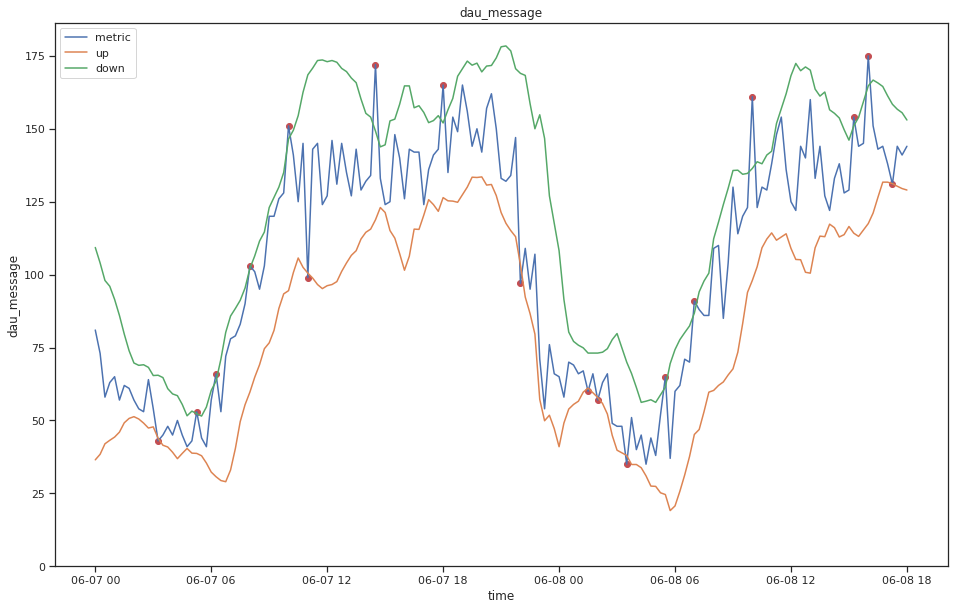

In [33]:
#рисуем график
#metric = df[0]
plt.figure(figsize=(16, 10))
plt.tight_layout()
x = df['FifteenMinutes']
y1 = df[metric]
y2 = df['minq']
y3 = df['maxq']

idx1 = np.argwhere(np.array(np.sign(y3 - y1))==-1).flatten()
idx2 = np.argwhere(np.array(np.sign(y1 - y2))==-1).flatten()

ax = plt.plot(x[idx1],y1[idx1], 'ro')
ax = plt.plot(x[idx2],y1[idx2], 'ro')
ax = sns.lineplot(x=df['FifteenMinutes'], y=df[metric],label = 'metric')
ax = sns.lineplot(x=df['FifteenMinutes'], y=df['minq'],label = 'up')
ax = sns.lineplot(x=df['FifteenMinutes'], y=df['maxq'],label = 'down')
# этот цикл нужен чтобы разрядить подписи координат по оси Х
for ind, label in enumerate(ax.get_xticklabels()): 
    if ind % 1 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set(xlabel='time') # задаем имя оси Х
ax.set(ylabel=metric) # задаем имя оси У
ax.set_title('{}'.format(metric)) # задаем заголовок графика
ax.set(ylim=(0, None)) # задаем лимит для оси У

In [6]:
np.argwhere(np.diff(np.sign(y2 - y1))).flatten()

array([ 12,  13,  43,  44,  87,  88, 101, 102, 103, 104, 109, 110, 164,
       165])

In [31]:
x[idx1]

21    2022-06-07 05:15:00
25    2022-06-07 06:15:00
32    2022-06-07 08:00:00
40    2022-06-07 10:00:00
58    2022-06-07 14:30:00
72    2022-06-07 18:00:00
118   2022-06-08 05:30:00
124   2022-06-08 07:00:00
136   2022-06-08 10:00:00
157   2022-06-08 15:15:00
160   2022-06-08 16:00:00
Name: FifteenMinutes, dtype: datetime64[ns]

In [8]:
y1[idx2]

12      54
13      43
43     145
44      99
87     147
88      97
101     67
102     60
103     66
104     57
109     48
110     35
164    138
165    131
Name: dau_message, dtype: uint64

In [23]:
np.array(np.sign(y1 - y2))

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.])

In [25]:
np.argwhere(np.array(np.sign(y1 - y2))==-1)

array([[ 13],
       [ 44],
       [ 88],
       [102],
       [104],
       [110],
       [165]])

In [30]:
np.argwhere(np.array(np.sign(y3 - y1))==-1).flatten()

array([ 21,  25,  32,  40,  58,  72, 118, 124, 136, 157, 160])